In [162]:
######## Jupyter and Ipython config and tweaks
# import ipy_autoreload
# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
###### fix notebook theme: make cells wide and add a margin to output cells
from IPython.core.display import display, HTML
display(HTML("""
<style>
  .container { width:99% !important; } 
  div.cell{
    width:100%;
    margin-left:1%;
    margin-right:auto;
  }
  div.output_area {
   display: -webkit-box;
   padding: 13px;
  }
</style>"""))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [286]:
##### Import libraries and define helper functions
#################################
import re
import time
import os
import sys, traceback
import gc
import numpy as np
#to dump objects
import cPickle as pickle
import operator
import itertools

import matplotlib
#matplotlib.use('PDF')
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib as mpl
fm = mpl.font_manager
fm.get_cachedir()
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
X_SMALL_SIZE = 8*2
SMALL_SIZE = 10*2
MEDIUM_SIZE = 12*2
BIGGER_SIZE = 14*2

rc('font', size=SMALL_SIZE)          # controls default text sizes
rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
rc('legend', fontsize=X_SMALL_SIZE)    # legend fontsize


import pylab
from numpy.core.function_base import linspace
from numpy.lib.function_base import meshgrid
from numpy.core.numeric import array
from matplotlib import colors
from mpl_toolkits.mplot3d.axes3d import Axes3D
#from mpl_toolkits import mplot3d
from matplotlib.collections import LineCollection, PolyCollection
from matplotlib.colors import colorConverter

from matplotlib import cm
from collections import OrderedDict, Set

import json, urllib
import copy
import msgpack
# import ipyparallel as ipp

In [283]:
################# Constants and Functions 
######################################################
#constants
experiment_time_stamp_idx=0
ble_mode_idx=1
tx_power_idx=2
tx_offset_idx=3
capture_idx=4
prr_1_idx=5
prr_2_idx=6
prr_ct_idx=7
rssi_avg_idx=8
rssi_stddev_idx=9
ts_delta_avg_idx=10
ts_delta_stddev_idx=11

class expdesc_usage_class:
  ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed = range(0,11)

class expsummary_usage_class:
  avg_per, stddev_per, avg_hopcount, stddev_hopcount, avg_onslots, stddev_onslots = range(0,6)

expdesc_usage = expdesc_usage_class()
expsummary_usage = expsummary_usage_class()
#constatnts
Ble_1Mbit=3 #/*!< 1 Mbit/s Bluetooth Low Energy */
Ble_2Mbit=4 #/*!< 2 Mbit/s Bluetooth Low Energy */
Ble_LR125Kbit=5 #/*!< Long range 125 kbit/s (TX Only - RX supports both) */
Ble_LR500Kbit=6 #/*!< Long range 500 kbit/s (TX Only - RX supports both) */
IEER802154_250Kbit=15
ble_mode_str_list = ["1Mbps", "2Mbps", "LR-125Kbps", "LR-500Kbps", "IEEE 802.15.4"]
ble_mode_str_list_compact = ["1M", "2M", "125K", "500K", "15.4"]
blueFloodSlotSizes = {Ble_1Mbit:0.5325, Ble_2Mbit:0.3636, Ble_LR500Kbit:1.324, Ble_LR125Kbit:3.677, IEER802154_250Kbit:1.829}
#ble_mode_str_dict = {Ble_1Mbit: "1Mbps", Ble_2Mbit:"2Mbps", Ble_LR125Kbit:"LR-125Kbps", Ble_LR500Kbit:"LR-500Kbps"}
ble_mode_str_dict = {Ble_1Mbit: "1 M", Ble_2Mbit:"2 M", Ble_LR125Kbit:"125 K", Ble_LR500Kbit:"500 K", IEER802154_250Kbit:"15.4"}

#String format print experiment name from experiment description dictionary
expname_fmt = "{}: {}_{}_{}_{}_{}_{} ble_mode_{}_txpower_{}_txoffset_{}_capt_{}_packet_size_{}_nch_{}_och_{}_ntx_{}_i_{}_testbed_{}"

def exp_desc_to_string(exp, expdesc):
  pp=[exp]+expdesc[exp][expdesc_usage.ts]+expdesc[exp][1:]
  return expname_fmt.format(*pp)

def ble_mode_str(m):
  return ble_mode_str_list[m-3] if (m>=3 or m<=6) else ("RF Mode Unknown %d" %(m))

def ble_mode_str_compact(m):
  return ble_mode_str_list_compact[m-3] if (m>=3 or m<=6) else ("RF Mode Unknown %d" %(m))

##unused
# plot_ts_delta_over = False
# plot_rssi_diff_over = False

linestylesDict = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])
#linestyles = linestylesDict.items()
linestyles = ['-', '--', '-.', ':',linestylesDict['densely dotted']]
markers = ['o', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'v', '^', '<', '>',]

def timing(f):
  def wrap(*args, **kwargs):
    time1 = time.time()
    ret = f(*args, **kwargs)
    time2 = time.time()
    print '%s function took %f ms' % (f.func_name, (time2-time1)*1000.0)
    return ret
  return wrap

@timing
def saveObject(userobj, filename):
  with open(filename, 'wb') as outputFile:
    gc.disable()
    pickle.dump(userobj, outputFile, pickle.HIGHEST_PROTOCOL)
    gc.enable()

@timing
def loadObject(filename):
  userobj = None
  with open(filename, 'rb') as inputFile:
    gc.disable()
    userobj = pickle.load(inputFile)
    gc.enable()
  return userobj

@timing
def saveObjectMP(userobj, filename):
  with open(filename, 'wb') as outputFile:
    gc.disable()
    msgpack.pack(userobj, outputFile)
    gc.enable()

@timing
def loadObjectMP(filename):
  userobj = None
  with open(filename, 'rb') as inputFile:
    gc.disable()
    userobj = msgpack.unpack(inputFile)
    gc.enable()
  return userobj

def tx_status_map_bad_rx(t):
  ''' 
  '-': rx ok
  '1': mote 1 tx
  '2': mote 2 tx
  'B': both tx
  ':': skipped slot
  ''' 
  if(t in ['-', '1', '2', 'B', ':', 'X', '\0']):
    return 0
  else:
    return 1

def tx_status_map_tx(t):
  ''' 
  '-': rx ok
  '1': mote 1 tx
  '2': mote 2 tx
  'B': both tx
  ':': skipped slot
  ''' 
  if(t in ['1', '2', 'B', 'X']):
    return 1
  else:
    return 0

def tx_status_map_tx2(t):
  ''' 
  '-': rx ok
  '1': mote 1 tx
  '2': mote 2 tx
  'B': both tx
  ':': skipped slot
  ''' 
  if(t in ['-', ':']):
    return 0
  elif(t in ['1', '2', 'B', 'X']):  
    return 1
  else:
    return 2
  
#### Functions to parse experiment logs, for Graz testbed
##############
#12345_2019_12_18_18_05_59_dirty-channel__ble_mode_6_txpower_4_txoffset_0_capture_0_packet_size_38_nch_3_och_0_ntx_4_i_0_testbed_GRAZ_TESTBED None
expname_regex = re.compile("(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)(?:_dirty-channel)?_?_ble_mode_(\d+)_txpower_(-?\d+)_txoffset_(-?\d+)_capture_(\d)(_packet_size_(\d+))?(_nch_(\d+))?(_och_(\d+))?(_ntx_(\d+))?(_i_(\d+))?(_testbed_(\w+)_TESTBED)?")
def parse_experiment_name(expname, nch=1, och=1, ntx=4, packet_size = 38):
  res = expname_regex.match(expname)
  #print dirname
  parsed = None
  if res:
    exp_number = int(res.group(1))
    ts = [int(res.group(2)), int(res.group(3)), int(res.group(4)), int(res.group(5)), int(res.group(6)),int(res.group(7))]
    ble_mode = int(res.group(8))
    txpower = int(res.group(9))
    txoffset = int(res.group(10))
    capture = int(res.group(11))
    initiator = None
    testbed = None
    if res.group(12):
        if str(res.group(12)).startswith("_packet_size_"):
            packet_size = int(res.group(13))
    if res.group(14):
        if str(res.group(14)).startswith("_nch_"):
            nch = int(res.group(15))
    if res.group(16):
        if str(res.group(16)).startswith("_och_"):
            och = int(res.group(17))
    if res.group(18):
        if str(res.group(18)).startswith("_ntx_"):
            ntx = int(res.group(19))
    if res.group(20):
        if str(res.group(20)).startswith("_i_"):
            initiator = int(res.group(21))       
    if res.group(22):
        if str(res.group(22)).startswith("_testbed_"):
            testbed = str(res.group(23))   
    parsed = [exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed]
  return parsed

#2019-12-19 00:32:53.102248|{tx-49} :B---AAAAAAAAAA...
#1574953250505373 {tx-111} :BCB-CAAAAA....
line_tx_regex = re.compile("(.*)[\s\|]\{tx-(\d+)\}\s(.*)")
def parse_tx_experiment_line(line):
  #93_2018_08_20_13_12_56_ble_mode_3_txpower_-20_txoffset_0_capture_0
  res = line_tx_regex.match(line)
  parsed = None
  if res:
    tsstr = str(res.group(1))
    rd = int(res.group(2))
    lline = str(res.group(3))
    parsed = tsstr, rd, lline
  return parsed

def process_tx_status(lline):
  lline=str(lline)
  is_initiator=False; synced=-1; sync_slot=-1; tot=0
  if len(lline) > 1: #and len(lline) <= Round.ROUND_LEN+1:
#                 if(len(lline)<Round.ROUND_LEN):
#                     lline = lline.rjust(Round.ROUND_LEN+ 1, "A")
#                     lline=lline.replace(':','A') #replace 
    ch=lline[1]
    #replace left dots with the letter, and remove the right dots!
    lline=re.sub(r'\.*$',r'',lline) #remove trailing dots
    lline=lline.replace('.',ch) #replace left dots with the first letter
    tx_status = lline[1:]  #remove ":"                  
    #print self.tx_status
    is_initiator, sync_slot, tot = [False, -1, 0]
    if len(tx_status) > 0:
      synced = tx_status.find("-") 
      sync_slot = 1 + synced if synced != -1 else -1  #first rx ok
      is_initiator = tx_status[0] in ['B', '1', '2']
      if is_initiator:
        sync_slot = 0

      tot=len(tx_status)
    
  return is_initiator, sync_slot, tot 


###############
testbeds={"GRAZ", "CAU", "HOME"}
def load_testbed_node_log_files(dirname, testbed="GRAZ"):
  #experiment_parameters
  dn = os.path.basename(os.path.normpath(dirname))
  if(testbed == "GRAZ"):
    exp_number = int(dn.split("_")[1])
    logfilename_regex = re.compile("log_(\d+)\.txt")
  else:
    exp_number = int(dn.split("_")[0])
    logfilename_regex = re.compile("raspi(\d+)")
    dirname = os.path.join(dirname, "logs")
  files=os.listdir(dirname)
  files.sort()
  nodes = dict()
  for nodefile in files:    
    fpath = os.path.join(dirname, nodefile)
    if(testbed == "GRAZ"):
      if not os.path.isfile(fpath):
        continue
    else:
      fpath = os.path.join(fpath, "log.txt")
      if not os.path.isfile(fpath):
        continue
        ##parse node number
    res = logfilename_regex.match(str(nodefile))
    if res is None:
      continue
    node_id=int(res.group(1))
#       print node_id
    #node_id=-1
    node_dict = dict()
    node_dict_is_initiator = dict()
    node_dict_sync_slot = dict()
    node_dict_tot_slot = dict()
    node_list_failed_rounds = list()

    ##parse tx status line
    for lline in open(fpath, 'r').readlines():
      if lline is None:
        continue
      lline=lline.strip()
      parsed = parse_tx_experiment_line(lline)
      if parsed is None:
        continue
      tsstr, rd, lline = parsed
      is_initiator, sync_slot, tot = process_tx_status(lline)
      if tot == 0: #corrupted tx log line
        continue
      node_dict[rd] = [is_initiator, sync_slot, tot]
      node_dict_is_initiator[rd] = is_initiator
      if sync_slot > -1: #recieved correctly
        node_dict_sync_slot[rd] = sync_slot
      elif not is_initiator:
        node_list_failed_rounds.append(rd)
      node_dict_tot_slot[rd] = tot
    
    nodes[node_id] = dict()
    nodes[node_id]["all"] = node_dict.copy() #shallow copy / reference pointer
    nodes[node_id]["sync"] = node_dict_sync_slot.copy() #shallow copy / reference pointer
    nodes[node_id]["is_initiator"] = node_dict_is_initiator.copy()
    nodes[node_id]["tot"] = node_dict_tot_slot.copy()
    nodes[node_id]["failed_rounds"] = node_list_failed_rounds
    syncedrounds = node_dict_sync_slot.keys()
    initiator_rounds = np.sum(node_dict_is_initiator.values())
    syncslots = [ s for s in node_dict_sync_slot.values() if s > 0]
    totslots = [ node_dict_tot_slot[i] for i in node_dict_tot_slot.keys() if not node_dict_is_initiator[i] ]
    if len(syncslots) > 0:
#       number_of_rounds = len(syncslots)
      nodes[node_id]["hopcount"] =  [ min(syncslots), max(syncslots), np.average(syncslots), np.std(syncslots) ]
      nodes[node_id]["totslots"] =  [ min(totslots), max(totslots), np.average(totslots), np.std(totslots) ]
    else:
#       number_of_rounds = initiator_rounds
      nodes[node_id]["hopcount"] =  [ 0, 0, 0, 0 ]
      nodes[node_id]["totslots"] =  [ 0, 0, 0, 0 ]
    
    number_of_failed_rounds = len(node_list_failed_rounds)
    #Fix PER: it was overestimated by doing the ratio of failed rounds to sync rounds, which was wrong.
    number_of_rounds = len(syncslots) + number_of_failed_rounds
    number_of_logged_rounds = len(nodes[node_id]["is_initiator"])
    initiator_node = ( number_of_rounds == 0 ) and ( number_of_logged_rounds > 0 ) and ( number_of_logged_rounds == len(nodes[node_id]["sync"]) )

#     initiator_node = ( number_of_failed_rounds == 0 ) and ( len(node_dict_is_initiator) == len(node_dict_sync_slot) )
    if initiator_node:
      nodes[node_id]["hopcount"] =  [ 0, 0, -1, 0 ]
      nodes[node_id]["totslots"] =  [ 0, 0, -1, 0 ]
      nodes[node_id]["PER"] = -1
    elif number_of_rounds == 0:
      nodes[node_id]["PER"] = 1
    else :
      nodes[node_id]["PER"] = 1.0*number_of_failed_rounds / number_of_rounds
      
  return nodes

def download_grazq(graz_qfile, graz_secretfile):
  with open(graz_secretfile, "r") as GRAZ_APIKEY:
    key=GRAZ_APIKEY.read()
    grazqurl="https://iti-testbed.tugraz.at/api/queue?key=%s" % (key)
    response = urllib.urlopen(grazqurl)
    with open(graz_qfile, "w") as graz_qfilef:
      graz_qfilef.write(response.read())

def load_grazq(graz_qfile):
  #grazq = json.loads(response.read())
  with open(graz_qfile, "r") as graz_qfilef:
    grazq = json.loads(graz_qfilef.read())
    return grazq

def load_grazq_online(graz_secretfile):
  with open(graz_secretfile, "r") as GRAZ_APIKEY:
    key=GRAZ_APIKEY.read()
    grazqurl="https://iti-testbed.tugraz.at/api/queue?key=%s" % (key)
    response = urllib.urlopen(grazqurl)
    grazq = json.loads(response.read())
    return grazq

###Load and process exp log files
### Parse experiments and save results
def load_logs_process_save_graz( wdirg, grazq, maxjobid, minjobid=0 ):
  expdict = dict()
  expdesc = dict()
  for job in grazq:
    exp_number=int(job["id"])
    if not (exp_number <= maxjobid and exp_number >= minjobid):
      continue
    n="%s_%s"% (job["id"], job["name"])
    parsed_exp=parse_experiment_name(n)
    if parsed_exp is not None:
      #print n, parse_experiment_name(n)
      [exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed] = parsed_exp
      exp_path = os.path.join(wdirg, "logs_%s" % (job["id"]))
      try:
        print n
        nodes = load_testbed_node_log_files(exp_path, "GRAZ")
        expdict[exp_number] = nodes.copy()
        expdesc[exp_number] = [ ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed]
        saveObject(nodes, os.path.join(exp_path, "nodes.pickle"))  
      except Exception as e:
        exc_type, exc_value, exc_traceback = sys.exc_info()
        print repr(traceback.format_exception(exc_type, exc_value, exc_traceback))

###Load and process exp log files
### Parse experiments and save results
def load_logs_process_save( wdirg, maxjobid, minjobid=0 ):
  jobs_dirs=os.listdir(wdirg)
  jobs_dirs.sort()
  #print jobs_dirs
  expdict = dict()
  expdesc = dict()
  for jobd in jobs_dirs:
    exp_path = os.path.join(wdirg, jobd)
    if os.path.isdir(exp_path):
      parsed_exp=parse_experiment_name(jobd)
      print jobd, parsed_exp
      if parsed_exp is not None:
        [exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed] = parsed_exp
        if not (exp_number <= maxjobid and exp_number >= minjobid):
          continue
        try:
          print "Parsing %s Testbed exp %d" % ( testbed, exp_number )
          nodes = load_testbed_node_log_files(exp_path, testbed)
          expdict[exp_number] = nodes.copy()
          expdesc[exp_number] = [ ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed]
          saveObject(nodes, os.path.join(exp_path, "nodes.pickle"))  
        except Exception as e:
          exc_type, exc_value, exc_traceback = sys.exc_info()
          print repr(traceback.format_exception(exc_type, exc_value, exc_traceback))
  return expdict, expdesc
          
def load_processed_logs_pickle_graz( wdirg, grazq, maxjobid, minjobid=0 ):
  expdict = dict()
  expdesc = dict()
  for job in grazq:
    exp_number=int(job["id"])
    if not (exp_number <= maxjobid and exp_number >= minjobid):
      continue
    n="%s_%s"% (job["id"], job["name"])
    parsed_exp=parse_experiment_name(n)
    if parsed_exp is not None:
      #print n, parse_experiment_name(n)
      exp_path = os.path.join(wdirg, "logs_%s" % (job["id"]))
      [exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed] = parsed_exp
      try:
        print "Loading %s Testbed exp %d" % ( testbed, exp_number )
        expdict[exp_number] = loadObject(os.path.join(exp_path, "nodes.pickle"))  
        expdesc[exp_number] = [ ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed]
      except Exception as e:
        exc_type, exc_value, exc_traceback = sys.exc_info()
        print repr(traceback.format_exception(exc_type, exc_value, exc_traceback))
  return expdict, expdesc

def load_processed_logs_pickle( wdirg, maxjobid, minjobid=0 ):
  expdict = dict()
  expdesc = dict()
  jobs_dirs=os.listdir(wdirg)
  jobs_dirs.sort()
  for jobd in jobs_dirs:
    exp_path = os.path.join(wdirg, jobd)
    if os.path.isdir(exp_path):
      parsed_exp=parse_experiment_name(jobd)
      if parsed_exp is not None:
        [exp_number, ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed] = parsed_exp
        if not (exp_number <= maxjobid and exp_number >= minjobid):
          continue
        try:
          print "Loading %s Testbed exp %d" % ( testbed, exp_number )
          expdict[exp_number] = loadObject(os.path.join(exp_path, "nodes.pickle"))  
          expdesc[exp_number] = [ ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed]
        except Exception as e:
          exc_type, exc_value, exc_traceback = sys.exc_info()
          print repr(traceback.format_exception(exc_type, exc_value, exc_traceback))
  return expdict, expdesc

def make_sorted_array_according_to_indices(a, idx):
  a = np.asarray(a)
  return a[idx]

def sort_summary_array_according_to_x(txpowerdata, blemodes):
    #sort according to x
    for b in blemodes:
      idx = np.argsort(txpowerdata[b]["x"])
      txpowerdata[b]["x"].sort()
      txpowerdata[b]["per1"] = make_sorted_array_according_to_indices(txpowerdata[b]["per1"], idx)
      txpowerdata[b]["perlen"] = make_sorted_array_according_to_indices(txpowerdata[b]["perlen"], idx)
      txpowerdata[b]["perstd1"] = make_sorted_array_according_to_indices(txpowerdata[b]["perstd1"], idx)
      txpowerdata[b]["hopcount1"] = make_sorted_array_according_to_indices(txpowerdata[b]["hopcount1"], idx)
      txpowerdata[b]["hopcountstd1"] = make_sorted_array_according_to_indices(txpowerdata[b]["hopcountstd1"], idx)
      txpowerdata[b]["hopcountlen"] = make_sorted_array_according_to_indices(txpowerdata[b]["hopcountlen"], idx)
      txpowerdata[b]["onslotslen"] = make_sorted_array_according_to_indices(txpowerdata[b]["onslotslen"], idx)
      txpowerdata[b]["onslots1"] = make_sorted_array_according_to_indices(txpowerdata[b]["onslots1"], idx)
      txpowerdata[b]["onslotsstd1"] = make_sorted_array_according_to_indices(txpowerdata[b]["onslotsstd1"], idx)
    return txpowerdata
  
def update_average_stddev(newdata, newstd, newlen, data, datalen, datastd):
  p=data * datalen + newdata * newlen
  pl=datalen + newlen
  pe=datastd * datalen + newstd * newlen
  updated_data_average = p / pl
  updated_std = pe / pl
  updated_len = pl
  return updated_data_average, updated_std, updated_len

#########################

def extract_exp_summary_parameterized(expdesc, expdict, startexp, blemodes, parameters, index):
  #parameters.insert(0,0) # insert fake ts at index 0
  parameters[index]=0 #make sure the parameter we plot against is zero here
  parameters[expdesc_usage.ble_mode]=0
#   [ ts0, ble_mode0, txpower0, txoffset0, capture0, packet_size0, nch0, och0, ntx0, initiator0, testbed0 ] = parameters
  expsummary=dict()
  txpowerdata = dict()
  for b in blemodes:
    txpowerdata[b] = dict()
    txpowerdata[b]["x"] = list()
    txpowerdata[b]["per1"] = list() #per experiment avg
    txpowerdata[b]["per"] = list() #avg of all experiments
    txpowerdata[b]["perlen"] = list()
    txpowerdata[b]["perstd1"] = list() #per experiment nodes stddev
    txpowerdata[b]["perstd"] = list() #stddev of all experiments averages
    txpowerdata[b]["hopcount1"] = list()
    txpowerdata[b]["hopcount"] = list()
    txpowerdata[b]["hopcountlen"] = list()
    txpowerdata[b]["hopcountstd"] = list()  
    txpowerdata[b]["hopcountstd1"] = list()  
    txpowerdata[b]["onslots1"] = list()
    txpowerdata[b]["onslots"] = list()
    txpowerdata[b]["onslotslen"] = list()
    txpowerdata[b]["onslotsstd"] = list()
    txpowerdata[b]["onslotsstd1"] = list()
  for expid in expdesc.keys():
    if expid >= startexp:
      #[ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed] = expdesc[expid]
      thisexpdesc = copy.deepcopy(expdesc[expid])
      #remove ts, and the x-axis parameter that we plot against:
      thisexpdesc[0]=0
      thisexpdesc[index]=0
      ble_mode=expdesc[expid][expdesc_usage.ble_mode]
      thisexpdesc[expdesc_usage.ble_mode]=0

      
      if thisexpdesc == parameters:
        nodes = expdict[expid].copy()
        per = [d["PER"] for d in list(nodes.values()) if d["PER"] > -1]
        if len(per) == 0:
          continue
        
        hopcounts = [ nodes[node_id]["hopcount"][2] for node_id in nodes.keys() if nodes[node_id]["hopcount"][2] > 0]
        onslots = [ nodes[node_id]["totslots"][2] for node_id in nodes.keys() if nodes[node_id]["totslots"][2] > 0]
        avg_per=np.mean(per)
        stddev_per=np.std(per)
        avg_onslots = np.mean(onslots)
        stddev_onslots = np.std(onslots)
        avg_hopcount=np.mean(hopcounts)
        stddev_hopcount=np.std(hopcounts)
        expsummary[expid] = [avg_per, stddev_per, avg_hopcount, stddev_hopcount, avg_onslots, stddev_onslots ]
        param = expdesc[expid][index]
        if param not in txpowerdata[ble_mode]["x"]:
          txpowerdata[ble_mode]["x"].append(param)
          txpowerdata[ble_mode]["per1"].append([])
          txpowerdata[ble_mode]["perlen"].append([])
          txpowerdata[ble_mode]["perstd1"].append([])
          txpowerdata[ble_mode]["hopcount1"].append([])
          txpowerdata[ble_mode]["hopcountstd1"].append([])
          txpowerdata[ble_mode]["hopcountlen"].append([])
          txpowerdata[ble_mode]["onslotslen"].append([])
          txpowerdata[ble_mode]["onslots1"].append([])
          txpowerdata[ble_mode]["onslotsstd1"].append([])
        # we have an experiment. do geometric mean to average the experiments results
        idx = txpowerdata[ble_mode]["x"].index(param) ### this seems redundant -- idx == len(txpowerdata[ble_mode]["x"])-1, if adding a new x, otherwise it is needed
        txpowerdata[ble_mode]["per1"][idx].append(avg_per)
        txpowerdata[ble_mode]["perlen"][idx].append(len(per))
        txpowerdata[ble_mode]["perstd1"][idx].append(stddev_per)
        txpowerdata[ble_mode]["hopcount1"][idx].append(avg_hopcount)
        txpowerdata[ble_mode]["hopcountstd1"][idx].append(stddev_hopcount)
        txpowerdata[ble_mode]["hopcountlen"][idx].append(len(hopcounts))
        txpowerdata[ble_mode]["onslotslen"][idx].append(len(onslots))
        txpowerdata[ble_mode]["onslots1"][idx].append(avg_onslots)
        txpowerdata[ble_mode]["onslotsstd1"][idx].append(stddev_onslots)

  txpowerdata = sort_summary_array_according_to_x(txpowerdata, blemodes)    
  # do avg, stddev over all experiments repititions 
  for b in blemodes:
    for idx, param in enumerate(txpowerdata[b]["x"]):
      txpowerdata[b]["per"].append(np.mean(txpowerdata[b]["per1"][idx]))
      txpowerdata[b]["hopcount"].append(np.mean(txpowerdata[b]["hopcount1"][idx]))
      txpowerdata[b]["onslots"].append(np.mean(txpowerdata[b]["onslots1"][idx]))
      txpowerdata[b]["perstd"].append(np.std(txpowerdata[b]["per1"][idx]))
      txpowerdata[b]["hopcountstd"].append(np.std(txpowerdata[b]["hopcount1"][idx]))
      txpowerdata[b]["onslotsstd"].append(np.std(txpowerdata[b]["onslots1"][idx]))

  return txpowerdata, expsummary

def plot_summary_plots(txpowerdata, blemodes, file_name, x_lbl, legend_idx=2, doplots=[1,1,1,0], legendloc='best', title=None):
  capsize=3
  markersize=3
  linewidth=1.6
#   linestyle=linestyles[0]
  norm = matplotlib.colors.Normalize(vmin=0, vmax=len(blemodes)+1)
  ncols=np.sum(doplots)
  if ncols <= 0:
    raise ValueError('doplots shall enable at least one plot.')
  figsize=(4,3) #width, height
  figscale=1.0 #1.7
  fig, axx = plt.subplots( ncols=ncols, sharey=False, sharex=True, figsize=(ncols*figsize[0]/figscale, figsize[1]/figscale) )
  if ncols == 1:
    subax=[axx] #trick to allow using indexing on the axes and have the same code for both cases (single vs multiple axes)
  else:
    subax=axx

  for counter, ble_mode in enumerate(blemodes):
    color=plt.get_cmap('Accent')(norm(counter))
    marker=markers[counter]
    linestyle=linestyles[counter]
    labelsarr=[None, None, None]
    if legend_idx is not None:
      labelsarr[legend_idx]=ble_mode_str_dict[ble_mode]

    if doplots[0]:
      subax[0].errorbar(txpowerdata[ble_mode]["x"], txpowerdata[ble_mode]["per"], yerr=txpowerdata[ble_mode]["perstd"], label=labelsarr[0], linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
    if doplots[1]:
      subax[doplots[0]].errorbar(txpowerdata[ble_mode]["x"], txpowerdata[ble_mode]["hopcount"], yerr=txpowerdata[ble_mode]["hopcountstd"], label=labelsarr[1], linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
    if doplots[2]:
      subax[doplots[0]+doplots[1]].errorbar(txpowerdata[ble_mode]["x"], txpowerdata[ble_mode]["onslots"], yerr=txpowerdata[ble_mode]["onslotsstd"], label=labelsarr[2], linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
    if doplots[3]:
      subax[doplots[0]+doplots[1]+doplots[2]].errorbar(txpowerdata[ble_mode]["x"], np.asarray(txpowerdata[ble_mode]["hopcount"])*blueFloodSlotSizes[ble_mode], yerr=np.asarray(txpowerdata[ble_mode]["hopcountstd"])*blueFloodSlotSizes[ble_mode], label=labelsarr[2], linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
  
  extract_x = [ txpowerdata[b]["x"] for b in blemodes ]
  extract_x = list(set(itertools.chain(*extract_x)))
#   extract_x.sort()
  ylabels=["End-to-End PER", "Hop Count", "Active Slots", "Latency [ms]"]

  for i, ax in enumerate(subax):
    ax.grid()
#     ax.set_xlim(np.min(np.min(extract_x))-0.5, np.max(np.max(extract_x))+0.5)
    ylim = ax.get_ylim()
    ax.set_ylim(-0.0000001, ylim[1]*1.1)
    ax.set_xticks(extract_x)
  #   ax.set_xlabel('TX power [dB]')
    ax.set_ylabel(ylabels[i])

  if doplots[0]:
    subax[0].set_ylim(-0.0000001, 1.1) #for PER
    subax[0].set_yscale('symlog', linthreshy=0.0001)
  if legend_idx is not None:
    #   subax[legend_idx].legend(loc="best",  ncol=2, columnspacing=0.3)
    subax[legend_idx].legend(loc=legendloc, borderaxespad=0.05,  ncol=3, columnspacing=0.25, labelspacing=0.25, handlelength=1.1, handletextpad=0.25, markerscale=0.5, frameon=True) #, mode="expand"
  if title is not None:
#     fig.suptitle(title, x=0.5, fontsize='medium', horizontalalignment = 'center')
    fig.text(0.5+fig.subplotpars.left/3, 0.96, title, ha='center')
  fig.text(0.5+fig.subplotpars.left/2, 0.01, x_lbl, ha='center')
  fig.tight_layout()
#   plt.subplots_adjust(left=0, top=2)
  plt.savefig(file_name, bbox_inches='tight', dpi=300)
  plt.show()



In [ ]:
##### Fix overestimated PER:
#### note that if you load the aggregated objects expdict_cau and expdict_graz, then you do not need to run the correction, as the results were computed using the fixed processing function

fix_old_processed_results_cau = 0
fix_old_processed_results_graz = 0
if fix_old_processed_results_cau:
  for exp in expdict_cau.keys(): #[1640]: 
    if exp < startexpcau:
      continue
    for node_id in expdict_cau[exp].keys():
      syncslots = [ s for s in expdict_cau[exp][node_id]["sync"].values() if s > 0]
      totslots = [ expdict_cau[exp][node_id]["tot"][i] for i in expdict_cau[exp][node_id]["tot"].keys() if not expdict_cau[exp][node_id]["is_initiator"][i] ]
      if len(syncslots) > 0:
        expdict_cau[exp][node_id]["hopcount"] =  [ min(syncslots), max(syncslots), np.average(syncslots), np.std(syncslots) ]
        expdict_cau[exp][node_id]["totslots"] =  [ min(totslots), max(totslots), np.average(totslots), np.std(totslots) ]
      else:
        expdict_cau[exp][node_id]["hopcount"] =  [ 0, 0, 0, 0 ]
        expdict_cau[exp][node_id]["totslots"] =  [ 0, 0, 0, 0 ]
    
      number_of_failed_rounds = len(expdict_cau[exp][node_id]["failed_rounds"])
      #Fix PER: it was overestimated by doing the ratio of failed rounds to sync rounds, which was wrong.
      number_of_rounds = len(syncslots) + number_of_failed_rounds
      number_of_logged_rounds = len(expdict_cau[exp][node_id]["is_initiator"])
      static_initiator = ( number_of_rounds == 0 ) and ( number_of_logged_rounds > 0 ) and ( number_of_logged_rounds == len(expdict_cau[exp][node_id]["sync"]) )
#       initiator_node = (number_of_rounds > 0 or static_initiator) and ( number_of_failed_rounds == 0 ) and ( len(totslots)==0 ) #( len( expdict_cau[exp][node_id]["is_initiator"] ) == len( expdict_cau[exp][node_id]["sync"] ) )
      if static_initiator:
        expdict_cau[exp][node_id]["hopcount"] =  [ 0, 0, -1, 0 ]
        expdict_cau[exp][node_id]["totslots"] =  [ 0, 0, -1, 0 ]
        expdict_cau[exp][node_id]["PER"] = -1
      elif number_of_rounds == 0:
        expdict_cau[exp][node_id]["PER"] = 1
      else :
        expdict_cau[exp][node_id]["PER"] = 1.0*number_of_failed_rounds / number_of_rounds
      if static_initiator or expdict_cau[exp][node_id]["PER"] > 0.9:
        print exp, node_id, number_of_rounds, number_of_failed_rounds, len(totslots), len(expdict_cau[exp][node_id]["sync"]), number_of_logged_rounds,expdict_cau[exp][node_id]["PER"]

if fix_old_processed_results_graz:
  for exp in expdict_graz.keys():
    for node_id in expdict_graz[exp].keys():
      syncslots = [ s for s in expdict_graz[exp][node_id]["sync"].values() if s > 0]
      totslots = [ expdict_graz[exp][node_id]["tot"][i] for i in expdict_graz[exp][node_id]["tot"].keys() if not expdict_graz[exp][node_id]["is_initiator"][i] ]
      if len(syncslots) > 0:
        expdict_graz[exp][node_id]["hopcount"] =  [ min(syncslots), max(syncslots), np.average(syncslots), np.std(syncslots) ]
        expdict_graz[exp][node_id]["totslots"] =  [ min(totslots), max(totslots), np.average(totslots), np.std(totslots) ]
      else:
        expdict_graz[exp][node_id]["hopcount"] =  [ 0, 0, 0, 0 ]
        expdict_graz[exp][node_id]["totslots"] =  [ 0, 0, 0, 0 ]
      
      number_of_failed_rounds = len(expdict_graz[exp][node_id]["failed_rounds"])
      #Fix PER: it was overestimated by doing the ratio of failed rounds to sync rounds, which was wrong.
      number_of_rounds = len(syncslots) + number_of_failed_rounds
      number_of_logged_rounds = len(expdict_graz[exp][node_id]["is_initiator"])
      static_initiator = ( number_of_rounds == 0 ) and ( number_of_logged_rounds > 0 ) and ( number_of_logged_rounds == len(expdict_graz[exp][node_id]["sync"]) )
      if static_initiator:
        expdict_graz[exp][node_id]["hopcount"] =  [ 0, 0, -1, 0 ]
        expdict_graz[exp][node_id]["totslots"] =  [ 0, 0, -1, 0 ]
        expdict_graz[exp][node_id]["PER"] = -1
      elif number_of_rounds == 0:
        expdict_graz[exp][node_id]["PER"] = 1
      else :
        expdict_graz[exp][node_id]["PER"] = 1.0*number_of_failed_rounds / number_of_rounds
      if static_initiator or expdict_graz[exp][node_id]["PER"] > 0.9:
        print exp, node_id, number_of_rounds, number_of_failed_rounds, len(totslots), len(expdict_graz[exp][node_id]["sync"]), number_of_logged_rounds, expdict_graz[exp][node_id]["PER"]


In [212]:
process_logs_and_update_dictionary_graz=0
load_partial_logs_and_update_dictionary_graz=0
minjobid_graz=0
maxjobid_graz=34893
wdir="/Users/beshr/work/blueflood/examples/nrf-glossy/"
if process_logs_and_update_dictionary_graz:
  graz_secretfile="/Users/beshr/work/blueflood/examples/nrf-glossy/graz_apifile.secret"
  graz_qfile="/Users/beshr/work/blueflood/examples/nrf-glossy/graz_qfile.json"
#   grazq = load_grazq_online(graz_secretfile)
  download_grazq(graz_qfile, graz_secretfile)
  grazq = load_grazq(graz_qfile)
  expdict_graz3, expdesc_graz3 = load_logs_process_save_graz( os.path.join(wdir, "graz_testbed"), grazq, maxjobid_graz, minjobid_graz )
  expdict_graz.update(expdict_graz3)
  expdesc_graz.update(expdesc_graz3)
elif load_partial_logs_and_update_dictionary_graz:
  expdict_graz4, expdesc_graz4 = load_processed_logs_pickle_graz( os.path.join(wdir, "graz_testbed"), grazq, maxjobid_graz, minjobid_graz )
  expdict_graz.update(expdict_graz4)
  expdesc_graz.update(expdesc_graz4)

## print list of loaded experiments
# grazenums = list(expdesc_graz.keys())
# grazenums.sort()
# print grazenums
# del expdict_graz[27473], expdesc_graz[27473]
# del expdict_graz[32058], expdesc_graz[32058]
# del expdict_graz[32060], expdesc_graz[32060]

# wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/home_testbed"
# maxjobid_home=23250
# load_logs_process_save( wdirg, maxjobid_home )
# expdict_home, expdesc_home = load_processed_logs_pickle( wdirg, maxjobid_home )

wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed"
minjobid_cau=1661
maxjobid_cau=1724
# expdict_cau2, expdesc_cau2 = load_logs_process_save( wdirg, maxjobid_cau, minjobid_cau )
# ## expdict_cau, expdesc_cau = load_processed_logs_pickle( wdirg, maxjobid_cau, minjobid_cau )
# ## expdict_cau2, expdesc_cau2 = load_processed_logs_pickle( wdirg, maxjobid_cau, minjobid_cau )
# expdict_cau.update(expdict_cau2)
# expdesc_cau.update(expdesc_cau2)
# print expdesc_cau
# minjobid_cau=1725
# maxjobid_cau=1744
# expdict_collect_cau, expdesc_collect_cau = load_logs_process_save( wdirg, maxjobid_cau, minjobid_cau )

save_data_graz = 0
save_data_cau = 0
load_data_graz = 0
load_data_cau = 0
#### Save processed results and experments summaries
wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed"
if save_data_graz:
  saveObject(txpowerdata_graz_ntx, os.path.join(wdirg, "txpowerdata_graz_ntx.pickle"))
  saveObject(expdesc_graz, os.path.join(wdirg, "expdesc_graz.pickle"))
  saveObject(expdict_graz, os.path.join(wdirg, "expdict_graz.pickle"))
  saveObject(expsummary_all_graz, os.path.join(wdirg, "expsummary_all_graz.pickle"))
elif load_data_graz:
  txpowerdata_graz_ntx = loadObject(os.path.join(wdirg, "txpowerdata_graz_ntx.pickle"))
  expdesc_graz = loadObject(os.path.join(wdirg, "expdesc_graz.pickle"))
  expdict_graz = loadObject(os.path.join(wdirg, "expdict_graz.pickle"))
  expsummary_all_graz = loadObject(os.path.join(wdirg, "expsummary_all_graz.pickle"))

wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed"
if save_data_cau:
  saveObject(txpowerdata_cau_ntx, os.path.join(wdirg, "txpowerdata_cau_ntx.pickle"))
  saveObject(expdesc_cau, os.path.join(wdirg, "expdesc_cau.pickle"))
  saveObject(expdict_cau, os.path.join(wdirg, "expdict_cau.pickle"))
  saveObject(expsummary_all_cau, os.path.join(wdirg, "expsummary_all_cau.pickle"))
elif load_data_cau:
  txpowerdata_cau_ntx = loadObject(os.path.join(wdirg, "txpowerdata_cau_ntx.pickle"))
  expdesc_cau = loadObject(os.path.join(wdirg, "expdesc_cau.pickle"))
  expdict_cau = loadObject(os.path.join(wdirg, "expdict_cau.pickle"))
  expsummary_all_cau = loadObject(os.path.join(wdirg, "expsummary_all_cau.pickle"))



# saveObject(expdesc_cau, os.path.join(wdirg, "expdesc_cau_test.pickle"))
# saveObjectMP(expdict_cau, os.path.join(wdirg, "expdict_cau.mp"))
# expdesc_cau_test = loadObject(os.path.join(wdirg, "expdesc_cau_test.pickle"))
# expdict_cau_MP = loadObjectMP(os.path.join(wdirg, "expdesc_cau_test.mp"))


In [223]:
# print nchdata_cau_ntx[4][5]["x"]

remove_failed_exp_cau = 0
remove_failed_exp_graz = 0
if remove_failed_exp_cau:
  if not("failedexp" in locals() or "failedexp" in globals()):
    wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed"
    if os.path.exists(os.path.join(wdirg, "failedexp.pickle")):
      failedexp = loadObject(os.path.join(wdirg, "failedexp.pickle"))
    else:
      failedexp=dict()

  for exp in expdesc_cau.keys(): #range(startexpcau, 1724,1):
    if exp < startexpcau:
      continue
  # print expsummary_all_cau[exp]
  # print expdesc_cau[exp], expdict_cau
    nologsnodes=[ (i, expdict_cau[exp][i]["PER"] ) for i in expdict_cau[exp].keys() if  (expdict_cau[exp][i]["PER"] < 0 and i!=1) or expdict_cau[exp][i]["PER"] > 0.9]
    if len(nologsnodes) > 0:
      print exp_desc_to_string(exp, expdesc_cau), len(nologsnodes)
      failedexp[exp] = dict()
      failedexp[exp]["name"] = exp_desc_to_string(exp, expdesc_cau)
      failedexp[exp]["failed"] = nologsnodes

#       try:
#         if expdesc_cau.has_key(exp):
#           failedexp[exp]["desc"] = expdesc_cau[exp]
#           del expdesc_cau[exp] 
#         if expdict_cau.has_key(exp):
#           failedexp[exp]["dict"] = expdict_cau[exp]
#           del expdict_cau[exp] 
#         if expsummary_all_cau.has_key(exp):
#           failedexp[exp]["summary"] = expsummary_all_cau[exp]
#           del expsummary_all_cau[exp]
#       except e as Exception:
#         print e
# wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed"
# saveObject(failedexp, os.path.join(wdirg, "failedexp.pickle"))
#   del failedexp
if remove_failed_exp_graz:
  if not("failedexpgraz" in locals() or "failedexpgraz" in globals()):
    wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed"
    if os.path.exists(os.path.join(wdirg, "failedexpgraz.pickle")):
      failedexpgraz = loadObject(os.path.join(wdirg, "failedexpgraz.pickle"))
    else:
      failedexpgraz = dict()
  for exp in expdesc_graz.keys(): #range(startexpcau, 1724,1):
    if exp < startexpgraz:
      continue

    nologsnodesgraz=[ (i, expdict_graz[exp][i]["PER"] ) for i in expdict_graz[exp].keys() if  (expdict_graz[exp][i]["PER"] < 0 and i!=100) or expdict_graz[exp][i]["PER"] > 0.9]
    if len(nologsnodesgraz) > 0:
      print exp_desc_to_string(exp, expdesc_graz), len(nologsnodesgraz)
      failedexpgraz[exp] = dict()
      failedexpgraz[exp]["name"] = exp_desc_to_string(exp, expdesc_graz)
      failedexpgraz[exp]["failed"] = nologsnodesgraz

      try:
        if expdesc_graz.has_key(exp):
          failedexpgraz[exp]["desc"] = expdesc_graz[exp]
          del expdesc_graz[exp] 
        if expdict_graz.has_key(exp):
          failedexpgraz[exp]["dict"] = expdict_graz[exp]
          del expdict_graz[exp] 
        if expsummary_all_graz.has_key(exp):
          failedexpgraz[exp]["summary"] = expsummary_all_graz[exp]
          del expsummary_all_graz[exp]
      except e as Exception:
        print e
  wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed"
  saveObject(failedexpgraz, os.path.join(wdirg, "failedexpgraz.pickle"))
  del failedexpgraz

restore_graz=0
if restore_graz:
  wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed"
  failedexpgraz = loadObject(os.path.join(wdirg, "failedexpgraz.pickle"))
  for exp in failedexpgraz.keys():
    expdesc_graz[exp] = copy.deepcopy(failedexpgraz[exp]["desc"])
    expdict_graz[exp] = copy.deepcopy(failedexpgraz[exp]["dict"])
    expsummary_all_graz[exp] = copy.deepcopy(failedexpgraz[exp]["summary"])
  print failedexpgraz[32179]["name"]
  del failedexpgraz

32055: 2020_1_29_15_29_54 ble_mode_15_txpower_8_txoffset_0_capt_0_packet_size_38_nch_3_och_0_ntx_3_i_0_testbed_GRAZ 47
32158: 2020_1_30_13_47_46 ble_mode_15_txpower_8_txoffset_0_capt_0_packet_size_38_nch_9_och_0_ntx_4_i_0_testbed_GRAZ 47
32069: 2020_1_29_16_1_2 ble_mode_15_txpower_8_txoffset_0_capt_0_packet_size_19_nch_3_och_0_ntx_4_i_0_testbed_GRAZ 47
32163: 2020_1_30_13_48_27 ble_mode_15_txpower_8_txoffset_0_capt_0_packet_size_38_nch_40_och_0_ntx_4_i_0_testbed_GRAZ 47
32168: 2020_1_30_13_49_28 ble_mode_15_txpower_8_txoffset_0_capt_0_packet_size_38_nch_3_och_0_ntx_3_i_0_testbed_GRAZ 47
32176: 2020_1_30_13_50_47 ble_mode_5_txpower_8_txoffset_0_capt_0_packet_size_76_nch_3_och_0_ntx_4_i_0_testbed_GRAZ 47
32178: 2020_1_30_13_51_3 ble_mode_15_txpower_8_txoffset_0_capt_0_packet_size_76_nch_3_och_0_ntx_4_i_0_testbed_GRAZ 47
32180: 2020_1_30_14_0_7 ble_mode_4_txpower_0_txoffset_0_capt_0_packet_size_38_nch_3_och_0_ntx_2_i_0_testbed_GRAZ 15
32183: 2020_1_30_14_0_32 ble_mode_15_txpower_0_txoffse

In [287]:
######## aggregate experiments 
[ts0, ble_mode0, txpower0, txoffset0, capture0, packet_size0, nch0, och0, ntx0, initiator0] = [0, 3, 0, 0, 0, 38, 3, 0, 8, 0]

blemodes = ble_mode_str_dict.keys()
blemodes.sort()
startexpgraz=23245
startexpcau=1148
ntxx=[2, 3, 4, 8]
txpowerx=[-8, -4, 0, 4, 8]
do_txpower_cau=0
do_txpower_graz=0
do_nch_cau = 0
do_nch_graz = 0
do_packet_size_cau = 1
do_packet_size_graz = 1
do_ntx_cau = 0
do_ntx_graz = 0

if do_ntx_cau:
  # fixntx
  expdesc_cau_fixed_ntx = copy.deepcopy(expdesc_cau)
  for exp in expdesc_cau_fixed_ntx.keys():
    expdesc_cau_fixed_ntx[exp][expdesc_usage.ntx] = expdesc_cau[exp][expdesc_usage.ntx] - 1
  param_index = expdesc_usage.ntx
  testbed0="CAU"
  expsummary_ntx_cau=dict()
  ntxdata_cau_txpower=dict()
  for txpower0 in txpowerx:
    param0 = [ ts0, ble_mode0, txpower0, txoffset0, capture0, packet_size0, nch0, och0, ntx0, initiator0, testbed0 ]
    ntxdata_cau_txpowerx, expsummary_ntx_cau_txpowerx =extract_exp_summary_parameterized(expdesc_cau_fixed_ntx, expdict_cau, startexpcau, blemodes, param0, param_index)
    expsummary_ntx_cau.update(expsummary_ntx_cau_txpowerx)
    ntxdata_cau_txpower[txpower0]=ntxdata_cau_txpowerx.copy()

if do_ntx_graz:
  param_index = expdesc_usage.ntx
    # fixntx
  expdesc_graz_fixed_ntx = copy.deepcopy(expdesc_graz)
  for exp in expdesc_graz_fixed_ntx.keys():
    expdesc_graz_fixed_ntx[exp][expdesc_usage.ntx] = expdesc_graz[exp][expdesc_usage.ntx] - 1
  testbed0="GRAZ"
  expsummary_ntx_graz=dict()
  ntxdata_graz_txpower=dict()
  for txpower0 in txpowerx:
    param0 = [ ts0, ble_mode0, txpower0, txoffset0, capture0, packet_size0, nch0, och0, ntx0, initiator0, testbed0 ]
    ntxdata_graz_txpowerx, expsummary_ntx_graz_txpowerx =extract_exp_summary_parameterized(expdesc_graz_fixed_ntx, expdict_graz, startexpgraz, blemodes, param0, param_index)
    expsummary_ntx_graz.update(expsummary_ntx_graz_txpowerx)
    ntxdata_graz_txpower[txpower0]=ntxdata_graz_txpowerx.copy()
    
if do_packet_size_graz:
  param_index = expdesc_usage.packet_size
  testbed0="GRAZ"
  expsummary_packet_size_graz=dict()
  packet_sizedata_graz_txpower=dict()
  ntx0 = 4
  for txpower0 in txpowerx:
    param0 = [ ts0, ble_mode0, txpower0, txoffset0, capture0, packet_size0, nch0, och0, ntx0, initiator0, testbed0 ]
    packet_sizedata_graz_ntxx, expsummary_packet_size_graz_ntxx =extract_exp_summary_parameterized(expdesc_graz, expdict_graz, startexpgraz, blemodes, param0, param_index)
    expsummary_packet_size_graz.update(expsummary_packet_size_graz_ntxx)
    packet_sizedata_graz_txpower[txpower0]=packet_sizedata_graz_ntxx.copy()
    
if do_packet_size_cau:
  param_index = expdesc_usage.packet_size
  testbed0="CAU"
  expsummary_packet_size_cau=dict()
  packet_sizedata_cau_txpower=dict()
  ntx0 = 4
  for txpower0 in txpowerx:
    param0 = [ ts0, ble_mode0, txpower0, txoffset0, capture0, packet_size0, nch0, och0, ntx0, initiator0, testbed0 ]
    packet_sizedata_cau_ntxx, expsummary_packet_size_cau_ntxx =extract_exp_summary_parameterized(expdesc_cau, expdict_cau, startexpcau, blemodes, param0, param_index)
    expsummary_packet_size_cau.update(expsummary_packet_size_cau_ntxx)
    packet_sizedata_cau_txpower[txpower0]=packet_sizedata_cau_ntxx.copy()

if do_nch_graz:
  param_index = expdesc_usage.nch
  testbed0="GRAZ"
  expsummary_nch_graz=dict()
  nchdata_graz_ntx=dict()
  for ntx0 in ntxx:
    param0 = [ ts0, ble_mode0, txpower0, txoffset0, capture0, packet_size0, nch0, och0, ntx0, initiator0, testbed0 ]
    nchdata_graz_ntxx, expsummary_nch_graz_ntxx = extract_exp_summary_parameterized(expdesc_graz, expdict_graz, startexpgraz, blemodes, param0, param_index)
    expsummary_nch_graz.update(expsummary_nch_graz_ntxx)
    nchdata_graz_ntx[ntx0]=nchdata_graz_ntxx.copy()
    
if do_nch_cau:
  param_index = expdesc_usage.nch
  testbed0="CAU"
  expsummary_nch_cau=dict()
  nchdata_cau_ntx=dict()
  for ntx0 in ntxx:
    param0 = [ ts0, ble_mode0, txpower0, txoffset0, capture0, packet_size0, nch0, och0, ntx0, initiator0, testbed0 ]
    nchdata_cau_ntxx, expsummary_nch_cau_ntxx = extract_exp_summary_parameterized(expdesc_cau, expdict_cau, startexpcau, blemodes, param0, param_index)
    expsummary_nch_cau.update(expsummary_nch_cau_ntxx)
    nchdata_cau_ntx[ntx0]=nchdata_cau_ntxx.copy()
  
if do_txpower_cau:
  param_index = expdesc_usage.txpower
  testbed0="CAU"
  expsummary_cau=dict()
  txpowerdata_cau_ntx=dict()
  for ntx0 in ntxx:
    param0 = [ ts0, ble_mode0, txpower0, txoffset0, capture0, packet_size0, nch0, och0, ntx0, initiator0, testbed0 ]
    txpowerdata_cau_ntxx, expsummary_cau_ntxx = extract_exp_summary_parameterized(expdesc_cau, expdict_cau, startexpcau, blemodes, param0, param_index)
    expsummary_cau.update(expsummary_cau_ntxx)
    txpowerdata_cau_ntx[ntx0]=txpowerdata_cau_ntxx.copy()

if do_txpower_graz:
  param_index = expdesc_usage.txpower
  testbed0="GRAZ"
  expsummary_graz=dict()
  txpowerdata_graz_ntx=dict()
  for ntx0 in ntxx:
    param0 = [ ts0, ble_mode0, txpower0, txoffset0, capture0, packet_size0, nch0, och0, ntx0, initiator0, testbed0 ]
    txpowerdata_graz_ntxx, expsummary_graz_ntxx = extract_exp_summary_parameterized(expdesc_graz, expdict_graz, startexpgraz, blemodes, param0, param_index)
    expsummary_graz.update(expsummary_graz_ntxx)
    txpowerdata_graz_ntx[ntx0]=txpowerdata_graz_ntxx.copy()

expsummary_all_cau=dict()
expsummary_all_cau.update(expsummary_ntx_cau)
expsummary_all_cau.update(expsummary_packet_size_cau)
expsummary_all_cau.update(expsummary_nch_cau)
expsummary_all_cau.update(expsummary_cau)

expsummary_all_graz=dict()
expsummary_all_graz.update(expsummary_ntx_graz)
expsummary_all_graz.update(expsummary_packet_size_graz)
expsummary_all_graz.update(expsummary_nch_graz)
expsummary_all_graz.update(expsummary_graz)

# startexphome=40
# txpowerdata_home, expsummary_home = extract_exp_summary(expdesc_home, expdict_home, startexphome, blemodes, [txoffset0, capture0, packet_size0, nch0, och0, ntx0])

In [225]:
print_low_per_cau=0
print_low_per_graz=1

if print_low_per_cau:
  high_per_exp_cau = [ (exp, expsummary_all_cau[exp][expsummary_usage.avg_per], expdesc_cau[exp]) for exp in expsummary_all_cau.keys() if expsummary_all_cau[exp][expsummary_usage.avg_per] > 0.8]
  # print high_per_exp
  for exp in [e[0] for e in high_per_exp_cau]:
    per=expsummary_all_cau[exp][expsummary_usage.avg_per]
    print exp_desc_to_string(exp, expdesc_cau) + "PER: {:.3}".format(per)
  #   print exp, expsummary_all_cau[exp][expsummary_usage.avg_per]
    print [ (i, expdict_cau[exp][i]["PER"] ) for i in expdict_cau[exp].keys() if  expdict_cau[exp][i]["PER"] > expsummary_all_cau[exp][expsummary_usage.avg_per]]

if print_low_per_graz:
  high_per_exp_graz = [ (exp, expsummary_all_graz[exp][expsummary_usage.avg_per], expdesc_graz[exp]) for exp in expsummary_all_graz.keys() if expsummary_all_graz[exp][expsummary_usage.avg_per] > 0.8]
  # print high_per_exp
  for exp in [e[0] for e in high_per_exp_graz]:
    per=expsummary_all_graz[exp][expsummary_usage.avg_per]
    print exp_desc_to_string(exp, expdesc_graz) + "PER: {:.3}".format(per)
  #   print exp, expsummary_all_graz[exp][expsummary_usage.avg_per]
    print [ (i, expdict_graz[exp][i]["PER"] ) for i in expdict_graz[exp].keys() if  expdict_graz[exp][i]["PER"] > expsummary_all_graz[exp][expsummary_usage.avg_per]]

# [ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed] = expdesc[expid]
# exptext_graz = [ "%d: mode %d @%ddb, %d ntx, PER %0.3f%% " % (expid, expdesc_graz[expid][1], expdesc_graz[expid][2], expdesc_graz[expid][8], expsummary_graz_ntx4[expid][0]*100) for expid in expsummary_graz_ntx4.keys() ]
# print exptext_graz
# exptext_ntx4_cau = [ "%d: mode %d @%ddb, %d ntx, PER %0.3f%% " % (expid, expdesc_cau[expid][1], expdesc_cau[expid][2], expdesc_cau[expid][8], expsummary_cau_ntx4[expid][0]*100) for expid in expsummary_cau_ntx4.keys() ]
# print exptext_ntx4_cau

# wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed"
# minjobid_graz=27424
# maxjobid_graz=27425
# load_logs_process_save_graz( wdirg, grazq, maxjobid_graz, minjobid_graz )
# expdict_g, expdesc_g = load_processed_logs_pickle_graz( wdirg, grazq, maxjobid_graz, minjobid_graz )
# print [ (i, expdict_g[27424][i]["PER"]) for i in expdict_g[27424].keys() ]
# print [ (i, expdict_g[1207][i]["PER"]) for i in expdict_cau[1207].keys() ]
# print "[avg_per, stddev_per, avg_hopcount, stddev_hopcount, avg_onslots, stddev_onslots ]", expsummary_graz[27424]
# high_per_expsummary_cau = high_per_expdesc_cau = high_per_expdict_cau = dict()
# high_per_exp_graz = [ (exp, expsummary_graz[exp][expsummary_usage.avg_per], expdesc_graz[exp]) for exp in expsummary_graz.keys() if expsummary_graz[exp][expsummary_usage.avg_per] > 0.1]
# print high_per_exp_graz
# for exp in [e[0] for e in high_per_exp_graz]:
#   print exp, expsummary_graz[exp][expsummary_usage.avg_per], '\n', [ (i, expdict_graz[exp][i]["PER"] ) for i in expdict_graz[exp].keys() if  expdict_graz[exp][i]["PER"] > 0.9 ]#expsummary_graz[exp][expsummary_usage.avg_per]]

### delete graz experiments with txpower -2, as it does not cover the network:
# for exp in expsummary_graz.keys():
#   if expdesc_graz[exp][expdesc_usage.txpower] == -2:
#     print exp, expdesc_graz[exp]
#     del expdesc_graz[exp], expdict_graz[exp], expsummary_graz[exp]

##### Delete experiments that have unconnected nodes only: PER == 1 for these nodes -- check the logs and conform this was the join bug, before deleting!
##   high_per_expsummary_cau[exp] = copy.copy(expsummary_cau[exp])
##   high_per_expdesc_cau[exp] = copy.copy(expdesc_cau[exp])
##   high_per_expdict_cau[exp] = copy.copy(expdict_cau[exp])
###   del expdesc_cau[exp], expdict_cau[exp], expsummary_cau[exp]
### delete failed experiment:
### 1365: 2020_1_31_9_46_52 ble_mode_5_txpower_0_txoffset_0_capt_0_packet_size_38_nch_40_och_0_ntx_4_i_0_testbed_CAU PER: 0.158
### [(9, 1), (10, 1), (18, 1)]
# exp = 1365
# del expdesc_cau[exp], expdict_cau[exp], expsummary_all_cau[exp]

# for exp in expdesc_cau.keys():
#   pp=[exp]+expdesc_cau[exp][expdesc_usage.ts]+expdesc_cau[exp][1:]+[expsummary_all_cau[exp][expsummary_usage.avg_per]]
#   print expname_fmt.format(*pp)

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed/evaluate_ntx_plot_cautestbed_txpower_0_exp_1148_1724.pdf


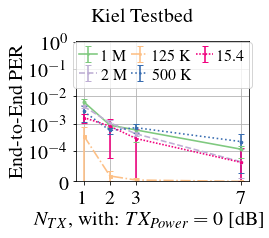

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed/evaluate_ntx_plot_graztestbed_txpower_0_exp_23245_34893.pdf


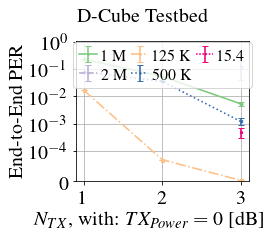

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed/evaluate_ntx_plot_cautestbed_txpower_8_exp_1148_1724.pdf


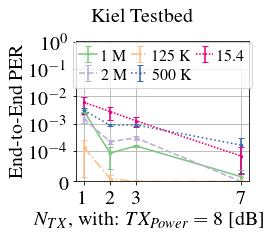

plotting: /Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed/evaluate_ntx_plot_graztestbed_txpower_8_exp_23245_34893.pdf


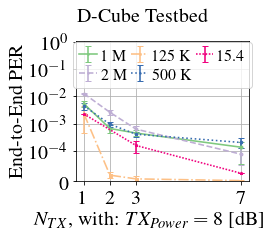

In [290]:
### note that the actual number of transmissions is ntx - 1!!! The plot labels are fixed accordingly
def plot_summary_testbed_ntx(testbed, parameters, startexp, endexp, x_lbl, paramplotname, data_variable_name, paramplotname2="ntx", paramplotvalue2=None, legend_idx=2, doplots=[1,1,1,0], legendloc='lower center', title=None):
  [txpower0, txoffset0, capture0, packet_size0, nch0, och0, ntx0] = parameters
  if paramplotvalue2 is None:
    paramplotvalue2=ntx0
  testbed = str(testbed).lower()
  wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/%s_testbed" %(testbed)
  plotfilename="evaluate_%s_plot_%stestbed_%s_%d_exp_%d_%d.pdf" % (paramplotname, testbed, paramplotname2, paramplotvalue2, startexp, endexp)
  file_name = os.path.join(wdirg, plotfilename)
  print "plotting: " + file_name
  plot_summary_plots(globals()[data_variable_name % (testbed)][paramplotvalue2], blemodes, file_name, x_lbl, legend_idx, doplots, legendloc, title)

plot_x_txpower = 0
plot_x_nch = 0
plot_x_packet_size = 0
plot_x_ntx = 1
plotcau = 1
plotgraz = 1
[txpower0, txoffset0, capture0, packet_size0, nch0, och0, ntx0] = [0, 0, 0, 38, 3, 0, 8]

if plot_x_ntx:
  for txpower0 in [0, 8]: #txpowerx: 
    params0 = [txpower0, txoffset0, capture0, packet_size0, nch0, och0, ntx0]
    x_lbl="$N_{TX}$, with: $TX_{Power}=%d$ [dB]" %(txpower0) #, $N_{Channels}=%d$ nch0
    if plotcau:
      plot_summary_testbed_ntx("cau", params0, startexpcau, maxjobid_cau, x_lbl, "ntx", "ntxdata_%s_txpower", "txpower", txpower0, legend_idx=0, doplots=[1, 0, 0, 0], legendloc='upper center', title="Kiel Testbed")
    if plotgraz:
      plot_summary_testbed_ntx("graz", params0, startexpgraz, maxjobid_graz, x_lbl, "ntx", "ntxdata_%s_txpower", "txpower", txpower0, legend_idx=0, doplots=[1, 0, 0, 0], legendloc='upper center', title="D-Cube Testbed")
    
if plot_x_txpower:
  for ntx0 in ntxx:
    params0 = [txpower0, txoffset0, capture0, packet_size0, nch0, och0, ntx0]
    x_lbl="$TX_{Power}$ [dB], with: $N_{Channels}=%d$, $N_{TX}=%d$" %(nch0, ntx0-1)
    if plotcau:
      plot_summary_testbed_ntx("cau", params0, startexpcau, maxjobid_cau, x_lbl, "txpower", "txpowerdata_%s_ntx", "ntx", ntx0, title="Kiel Testbed", doplots=[1,1,1,1])
    if plotgraz:
      plot_summary_testbed_ntx("graz", params0, startexpgraz, maxjobid_graz, x_lbl, "txpower", "txpowerdata_%s_ntx", "ntx", ntx0, title="D-Cube Testbed", doplots=[1,1,1,1])

if plot_x_nch:
  for ntx0 in [4]:
    params0 = [txpower0, txoffset0, capture0, packet_size0, nch0, och0, ntx0]
    x_lbl="$N_{Channels}$, with: $TX_{Power}=%d$ [dB], $N_{TX}=%d$" %(txpower0, ntx0-1)
    if plotcau:
      plot_summary_testbed_ntx("cau", params0, startexpcau, maxjobid_cau, x_lbl, "nch", "nchdata_%s_ntx", "ntx", ntx0, title="Kiel Testbed")
    if plotgraz:
      plot_summary_testbed_ntx("graz", params0, startexpgraz, maxjobid_graz, x_lbl, "nch", "nchdata_%s_ntx", "ntx", ntx0, title="D-Cube Testbed")

if plot_x_packet_size:
  ntx0=4
  for txpower0 in [0]: #txpowerx:
    params0 = [txpower0, txoffset0, capture0, packet_size0, nch0, och0, ntx0]
    x_lbl="$Packet_{Size}$, with: $TX_{Power}=%d$ [dB], $N_{TX}=%d$" %(txpower0, ntx0-1)
    if plotcau:
      plot_summary_testbed_ntx("cau", params0, startexpcau, maxjobid_cau, x_lbl, "packet_size", "packet_sizedata_%s_txpower", "txpower", txpower0, legend_idx=0, doplots=[1, 1, 0, 0], legendloc='upper center', title="Kiel Testbed")
#     if plotgraz:
#       plot_summary_testbed_ntx("graz", params0, startexpgraz, maxjobid_graz, x_lbl, "packet_size", "packet_sizedata_%s_txpower", "txpower", txpower0, legend_idx=0, doplots=[1, 1, 0, 0], legendloc='upper center', title="D-Cube Testbed")

In [ ]:
def plot_summary_boxplots(txpowerdata, blemodes, file_name):
  capsize=3
  markersize=3
  linewidth=1.5
  linestyle=linestyles[0]
  norm = matplotlib.colors.Normalize(vmin=0, vmax=len(blemodes)+1)

  #fig = plt.figure(figsize=(4, 6))  #width, height
  fig, axx = plt.subplots(ncols=3, sharey=False, sharex=True, figsize=(12,3))
  #axmain = fig.add_subplot(111,frameon=False)
  # Turn off axis lines and ticks of the big subplot
  #axmain.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
  #axx[1].set_ylim(80, 100.5)

  for counter, ble_mode in enumerate(blemodes):
    color=plt.get_cmap('Accent')(norm(counter))
    marker=markers[counter]
  #   if res != 0:
  #     txp_per_err = list(np.asarray(txpowerdata[ble_mode]["perstd"]) + res)
  #     txp_per =  list(np.asarray(txpowerdata[ble_mode]["per"]) + res)
  #   #   yerr = np.log10(txp_per_err)
  #   #   y=np.log10(txp_per)
  #     yerr = txp_per_err
  #     y=txp_per
  #   else:
      #shallow copy
    yerr=copy.copy(txpowerdata[ble_mode]["perstd"])
    y=copy.copy(txpowerdata[ble_mode]["per"])
    yerr1=copy.copy(txpowerdata[ble_mode]["hopcountstd"])
    y1=copy.copy(txpowerdata[ble_mode]["hopcount"])
    yerr2=copy.copy(txpowerdata[ble_mode]["onslotsstd"])
    y2=copy.copy(txpowerdata[ble_mode]["onslots"])
    axx[0].errorbar(txpowerdata[ble_mode]["x"], y, yerr=yerr, linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
    #axx[0].boxplot(y, positions=txpowerdata[ble_mode]["x"], notch=True)
    axx[1].errorbar(txpowerdata[ble_mode]["x"], y1, yerr=yerr1, label=ble_mode_str_dict[ble_mode], linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
    #axx[1].boxplot(y1, positions=txpowerdata[ble_mode]["x"], notch=True)
    axx[2].errorbar(txpowerdata[ble_mode]["x"], y2, yerr=yerr2, linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
    #axx[2].boxplot(y2, positions=txpowerdata[ble_mode]["x"], notch=True)

    axx[0].set_yscale('symlog', linthreshy=0.00001)
    axx[1].legend(loc="best",  ncol=2)
    
  ylabels=["E2E PER", "Hopcount", "Active slots"]
  for i, ax in enumerate(axx):
    ax.grid()
    # axx.set_yscale('log')
    #ax.set_xlim(min(txpowerdata[ble_mode]["x"])-0.2, max(txpowerdata[ble_mode]["x"])+0.2)
  #   ax.set_xlabel('TX power [dB]')
    ax.set_ylabel(ylabels[i])

  x_lbl="$TX_{Power}$ [dB], with: $N_{Channels}=%d$, $N_{TX}=%d$" %(nch0, ntx0-1)
  fig.text(0.5, 0.00, x_lbl, ha='center')
  fig.tight_layout()
  # plt.subplots_adjust(left=0, top=2)
  plt.savefig(file_name, bbox_inches='tight')
  plt.show()

In [ ]:
startexp=23245
wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed"
plotfilename="evaluate_txpower_boxplot_graztestbed-%d.pdf" % startexp
file_name = os.path.join(wdirg, plotfilename)
print "plotting: " + file_name
plot_summary_boxplots(txpowerdata_graz, blemodes, file_name)

startexp=1
wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed"
plotfilename="evaluate_txpower_boxplot_cautestbed-%d.pdf" % startexp
file_name = os.path.join(wdirg, plotfilename)
print "plotting: " + file_name
plot_summary_boxplots(txpowerdata_cau, blemodes, file_name)

wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/home_testbed"
plotfilename="evaluate_txpower_boxplot_hometestbed-%d.pdf" % startexp
file_name = os.path.join(wdirg, plotfilename)
print "plotting: " + file_name
plot_summary_boxplots(txpowerdata_home, blemodes, file_name)

In [ ]:
### Parse experiment and save results
wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed"
exp_path = os.path.join(wdirg, "logs_23263")
nodes = load_testbed_node_log_files(exp_path);
saveObject(nodes, os.path.join(exp_path, "nodes.pickle"))       

In [ ]:
### Load parsed results
expid=23252
wdirg="/Users/beshr/work/blueflood/examples/nrf-glossy/graz_testbed"
exp_path = os.path.join(wdirg, "logs_%d" % (expid))
nodes = loadObject(os.path.join(exp_path, "nodes.pickle"))    

In [ ]:
#y1 is plotted on log scale axis
def plot_exp(x, xticks, x_lbl, lbl, y1, yerr1, y2, yerr2, y3, yerr3, ylabels, expn, wdirg, color, fig=None, axx=None, marker='*'):
  capsize=3
  markersize=3
  linewidth=1.5
  linestyle=linestyles[0]
  #color='b'

  #fig = plt.figure(figsize=(4, 6))  #width, height
  if fig is None or axx is None:
    fig, axx = plt.subplots(ncols=3, sharey=False, sharex=True, figsize=(12,3))
#   plotfilename="plot_graztestbed_exp%d.pdf" % expn
#   file_name = os.path.join(wdirg, plotfilename)
  #print "plotting: " + x_lbl + ", " + lbl
  axx[0].errorbar(x, y1, yerr=yerr1, linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
  axx[1].errorbar(x, y2, yerr=yerr2, label=lbl, linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
  axx[2].errorbar(x, y3, yerr=yerr3, linestyle=linestyle, color = color, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
  #log scale, but make a linear region around zero to avoid problems with zero, as log(0) is nan
  axx[0].set_yscale('symlog', linthreshy=0.00001)
  axx[1].legend(loc="best",  ncol=1)

  for i, ax in enumerate(axx):
    ax.grid()
    #ax.set_xlim(min(txpowerdata[ble_mode]["x"])-0.2, max(txpowerdata[ble_mode]["x"])+0.2)
    ax.set_ylabel(ylabels[i])
    ax.set_xticks(x, minor=True)
    ax.set_xticklabels(xticks, minor=True)
    #ax.set_xticklabels(xticks[0:10:len(xticks)], minor=False)

    ax.minorticks_off()

  if x_lbl is not None:
    fig.text(0.5, 0.00, x_lbl, ha='center')
  fig.tight_layout()
  #plt.savefig(file_name, bbox_inches='tight')
  #plt.show()
  return fig, axx

In [ ]:
#plot for one tx power
def plot_micro_view_for_txpowers(expdict, expdesc, startexp, blemodes, txpowerset, params, plotnametemplate, wdirg):
  [txoffset0, capture0, packet_size0, nch0, och0, ntx0]=params
  norm = matplotlib.colors.Normalize(vmin=0, vmax=len(blemodes)+1)
  ncols=4
  for txpower0 in txpowerset:
    fig, axx = plt.subplots(ncols=ncols, sharey=False, sharex=False, figsize=(4*ncols,3))
    x_lbl_written = False
    for expid in expdesc.keys():
      if expid >= startexp:
        [ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed] = expdesc[expid]
        if [txpower, txoffset, capture, packet_size, nch, och, ntx] == [txpower0, txoffset0, capture0, packet_size0, nch0, och0, ntx0]:
          nodes=expdict[expid].copy()
          nodeids=list(nodes.keys())
          nodeids.sort()
          x = range(0, len(nodeids), 1)

          y1 = [nodes[i]["PER"] if nodes[i]["PER"] != -1 else 0 for i in nodeids ]
          #yerr1 = np.std(y1)
          yerr1 = None   

#           syncslots = [list(np.asarray(nodes[i]["sync"].values()))]
          syncslots = [nodes[i]["all"].values() for i in nodeids]
          syncslots = [[ d[1] for d in row if not d[0] ] for row in syncslots ]
##         print syncslots
          syncslots_flat = list(itertools.chain(*syncslots))
          y2 = [nodes[i]["hopcount"][2] if nodes[i]["hopcount"][2] > -1 else 0 for i in nodeids]
          yerr2 = [nodes[i]["hopcount"][3] if nodes[i]["hopcount"][2] > -1 else 0 for i in nodeids]
          #print syncslots
#           y2 = np.mean(syncslots ,axis=1)
#           y2 = [np.mean(s) if len(s)>0 else 0 for s in syncslots]
#           yerr2 = [np.std(s) if len(s)>0 else 0 for s in syncslots]

#           y3 = [np.mean(nodes[i]["tot"].values()) for i in nodeids]
#           yerr3 = [np.std(nodes[i]["tot"].values()) for i in nodeids]
          y3 = [nodes[i]["totslots"][2] if nodes[i]["totslots"][2] > -1 else 0 for i in nodeids]
          yerr3 = [nodes[i]["totslots"][3] if nodes[i]["totslots"][2] > -1 else 0 for i in nodeids]
    
          color=plt.get_cmap('Accent')(norm(blemodes.index(ble_mode)))
          lbl = ble_mode_str_dict[ble_mode]
          #x_lbl0="Experiment %d, Node IDs" % expid
          x_lbl0="Node index. Parameters: $TX_{Power}$=%d dB, $N_{Channels}=%d$, $N_{TX}=%d$" %(txpower0, nch0, ntx0-1)
          if not x_lbl_written:
            x_lbl = x_lbl0
            x_lbl_written = True
          else:
            x_lbl=None
          ylabels=["E2E PER", "Hopcount", "Active slots", "Sync slot Histogram", "Sync slot CDF"]
          print "plotting: " + x_lbl0 + ", " + lbl
          plot_exp(x, nodeids, x_lbl, lbl, y1, yerr1, y2, yerr2, y3, yerr3, ylabels, expid, wdirg, color, marker=markers[blemodes.index(ble_mode)], fig=fig, axx=axx)

          n_bins=int(np.max(syncslots_flat))
          #print syncslots
          linewidth=1.5
          n, bins, patches = axx[3].hist(syncslots_flat, n_bins, density=True, histtype='step',cumulative=True, color=color, linewidth=linewidth)
          axx[3].set_xticks(bins, minor=True)
          axx[3].set_xticklabels(bins, minor=True)
          axx[3].minorticks_off()
          axx[3].grid()
          axx[3].grid()
  #         bin_edges, cdf, hist = do_cdf(chain)
  #         axx[4].errorbar(bin_edges, cdf, color=color, linestyle=linestyle, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
  #         axx[4].set_xticks(bin_edges, minor=True)
  #         axx[4].set_xticklabels(bin_edges, minor=True)

    plotfilename= plotnametemplate % txpower0
    file_name = os.path.join(wdirg, plotfilename)
    plt.savefig(file_name, bbox_inches='tight')
    plt.show()

In [ ]:
#plot for one rf mode
def plot_micro_view_for_rfmodes(expdict, expdesc, startexp, blemodes, txpowerset, params, plotnametemplate, wdirg):
  [txoffset0, capture0, packet_size0, nch0, och0, ntx0]=params
  norm = matplotlib.colors.Normalize(vmin=min(txpowerset), vmax=max(txpowerset)+1)
  ncols=4
  ble_mode_name=0
  for ble_mode0 in blemodes:
    fig, axx = plt.subplots(ncols=ncols, sharey=False, sharex=False, figsize=(4*ncols,3))
    x_lbl_written=False
    for expid in expdesc.keys():
      if expid >= startexp:
        [ts, ble_mode, txpower, txoffset, capture, packet_size, nch, och, ntx, initiator, testbed] = expdesc[expid]
        if (txpower in txpowerset) and ([ble_mode, txoffset, capture, packet_size, nch, och, ntx] == [ble_mode0, txoffset0, capture0, packet_size0, nch0, och0, ntx0]):
          ble_mode_name=ble_mode
          nodes=expdict[expid].copy()
          nodeids=list(nodes.keys())
          nodeids.sort()
          x = range(0, len(nodeids), 1)

          y1 = [nodes[i]["PER"] if nodes[i]["PER"] != -1 else 0 for i in nodeids ]
          #yerr1 = np.std(y1)
          yerr1 = None

          syncslots = [list(nodes[i]["all"].values()) for i in nodeids]
          syncslots = [[ d[1] for d in row if not d[0] ] for row in syncslots  ]
          
          syncslots_flat = list(itertools.chain(*syncslots))
          y2 = [np.mean(s) if len(s)>0 else 0 for s in syncslots]
          yerr2 = [np.std(s) if len(s)>0 else 0 for s in syncslots]
#           print len(y2), len(x)
#           print yerr2
#           syncslots = [list(np.asarray(nodes[i]["sync"].values()) + 1) if not nodes[i]["is_initiator"] else list(nodes[i]["sync"].values()) for i in nodeids]
#           syncslots_flat = list(itertools.chain(*syncslots))
#           y2 = [np.mean(s) for s in syncslots]
#           yerr2 = [np.std(s) for s in syncslots]

          y3 = [np.mean(nodes[i]["tot"].values()) for i in nodeids]
          yerr3 = [np.std(nodes[i]["tot"].values()) for i in nodeids]

          color=plt.get_cmap('Accent')(norm(txpower))
          lbl="$TX_{Power}$ %d dB" %(txpower)
          #x_lbl0="Experiment %d, Node IDs" % expid
          x_lbl0="Node index. Parameters: Mode: %s, $N_{Channels}=%d$, $N_{TX}=%d$" %(ble_mode_str_dict[ble_mode], nch, ntx-1)
          if not x_lbl_written:
            x_lbl = x_lbl0
            x_lbl_written = True
          else:
            x_lbl=None
          ylabels=["E2E PER", "Hopcount", "Active slots", "Sync slot Histogram", "Sync slot CDF"]
          print "plotting: " + x_lbl0 + ", " + lbl
          plot_exp(x, nodeids, x_lbl, lbl, y1, yerr1, y2, yerr2, y3, yerr3, ylabels, expid, wdirg, color, marker=markers[0], fig=fig, axx=axx)

          n_bins=int(np.max(syncslots_flat))
          #print syncslots
          linewidth=1.5
          n, bins, patches = axx[3].hist(syncslots_flat, n_bins, density=True, histtype='step',cumulative=True, color=color, linewidth=linewidth)
          axx[3].set_xticks(bins, minor=True)
          axx[3].set_xticklabels(bins, minor=True)
          axx[3].minorticks_off()
          axx[3].grid()
          axx[3].grid()
  #         bin_edges, cdf, hist = do_cdf(chain)
  #         axx[4].errorbar(bin_edges, cdf, color=color, linestyle=linestyle, marker=marker, markersize=markersize, capsize=capsize, elinewidth=linewidth, linewidth=linewidth)
  #         axx[4].set_xticks(bin_edges, minor=True)
  #         axx[4].set_xticklabels(bin_edges, minor=True)

    plotfilename= plotnametemplate % ble_mode_str_dict[ble_mode_name]
    file_name = os.path.join(wdirg, plotfilename)
    plt.savefig(file_name, bbox_inches='tight')
    plt.show()

In [ ]:
startexp=23245
blemodes = ble_mode_str_dict.keys()
blemodes.sort()
[txoffset0, capture0, packet_size0, nch0, och0, ntx0] = [0, 0, 38, 3, 0, 4]
params=[txoffset0, capture0, packet_size0, nch0, och0, ntx0]
txpowerset=[0, 2, 4, 8]
plotnametemplate = "plot_graztestbed_exp_txpower_%d.pdf"
plot_micro_view_for_txpowers(expdict_graz, expdesc_graz, startexp, blemodes, txpowerset, params, plotnametemplate, wdirg)

plotnametemplate = "plot_graztestbed_exp_rfmode_%s.pdf"
plot_micro_view_for_rfmodes(expdict_graz, expdesc_graz, startexp, blemodes, txpowerset, params, plotnametemplate, wdirg)

In [ ]:
blemodes = ble_mode_str_dict.keys()
blemodes.sort()
[txoffset0, capture0, packet_size0, nch0, och0, ntx0] = [0, 0, 38, 3, 0, 4]
txpowerset=[0, 2, 4]
params=[txoffset0, capture0, packet_size0, nch0, och0, ntx0]


In [ ]:
### Do some stats on parsed results
hopcounts = [d["hopcount"] for d in list(nodes.values())]
per = [d["PER"] for d in list(nodes.values())]
print ' ', np.average(hopcounts, axis=0), np.std(hopcounts, axis=0), np.percentile(hopcounts, 70, axis=0)
print ' ',  100*np.average(per, axis=0), 100*np.std(per, axis=0), 100*np.min(per, axis=0), \
100*np.max(per, axis=0)
# Absolute mean deviation 
avg_per=np.mean(per)
stddev_per=np.std(per)
print ' Avg PER, std dev, Absolute mean deviation', 100*avg_per, 100*stddev_per, 100*np.mean(np.absolute(per - avg_per)) 

In [ ]:
def do_cdf(series):
  ### from https://blog.finxter.com/numpy-cumsum/
  # s=Size of our data
  series_size=len(series)
  # Sort the data and set bins edges
  sorted_series = np.sort(series)
  bins = np.append(sorted_series, sorted_series[-1]+1)
  # Use the histogram function to bin the data
  hist1, bin_edges = np.histogram(series, bins = bins)
  # Account for the possible float data
  hist = hist1.astype(float)/series_size
  # Find the cdf
  cdf = np.cumsum(hist)
  return bin_edges[1:], cdf, hist1

def do_percentile(series):
  p=list()
  r=range(0,101,10)
  for i in r:
    p.append(np.percentile(series, i, axis=0))
  return r, p

# plot the cumulative histogram
x=hopcounts[3]
n_bins=int(np.max(x))
print x, n_bins
n, bins, patches = plt.hist(x, n_bins, density=True, histtype='step',cumulative=True, label='Empirical')
plt.show()

bin_edges, cdf, hist = do_cdf(hopcounts[3])
r, p = do_percentile(hopcounts[3])
# Plot the cdf
plt.plot(bin_edges, hist)
plt.show()
# Plot the cdf
plt.plot(bin_edges, cdf)
plt.show()
plt.plot(cdf, bin_edges)
plt.show()
plt.plot(r,p)
plt.show()

In [ ]:
for lline in [":A..--CC...", ":B---CCC--.....", ":-BBBBBBBB.....", ":B--------.....",":A.......-BBBB."]:
  lline=str(lline)
  is_initiator=False; synced=-1; sync_slot=-1; tot=0
  if len(lline) > 1: #and len(lline) <= Round.ROUND_LEN+1:
#                 if(len(lline)<Round.ROUND_LEN):
#                     lline = lline.rjust(Round.ROUND_LEN+ 1, "A")
#                     lline=lline.replace(':','A') #replace 
    ch=lline[1]
    #replace left dots with the letter, and remove the right dots!
    lline=re.sub(r'\.*$',r'',lline) #remove trailing dots
    lline=lline.replace('.',ch) #replace left dots with the first letter
    tx_status = lline[1:]  #remove ":"                  
    #print self.tx_status
    synced = tx_status.find("-") 
    sync_slot = 1 + synced if synced != -1 else -1  #first rx ok
    is_initiator = tx_status[0] in ['B', '1', '2']
    if is_initiator:
      sync_slot = 0

    tot=len(tx_status)
    
  print lline, is_initiator, sync_slot, tot 


In [ ]:
#! open -a Preview /Users/beshr/work/chaos/examples/nrf-glossy/exp-logs/evaluate_*.pdf
#wdir="/Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed"
! open -a Preview /Users/beshr/work/blueflood/examples/nrf-glossy/cau_testbed/*.pdf
#! open -a Preview /Users/beshr/work/chaos/examples/nrf-glossy/exp-logs/evaluate_txpower_plot0.pdf

In [ ]:
a=[2,1,0]
a=np.asarray(a)
b=9
c=list()
c.append(b)
c.append(b-1)
c.append(b+1)
print a, c
idx=np.argsort(a)
a.sort()
c = np.asarray(c)
c = c[idx]
print a, c
